Referencing Deep Learning in Python (2021) and "A Portable, Self-Contained Neuroprosthetic Hand with Deep Learning-Based Finger Control

In [1]:
import numpy as np
import datetime as dt
# import ipympl

emg_filename = r'Data\EMG_Mar_19_09_34_15.txt'
q_filename = r'Data\Q_Mar_19_09_33_45.txt'
DIM = 3

# Import from txt files
emg = np.loadtxt(emg_filename, dtype='O,'+'f8,'*12, delimiter=',', unpack=True, \
         converters={0: lambda d: dt.datetime.strptime(d.decode("utf-8"), '%H.%M.%S.%f').replace(year=2022)})
emgTimes = emg[0]
emg = np.vstack(emg[1:]).T

print("EMG Shape: ", emg.shape)

q = np.loadtxt(q_filename, dtype='O,'+'f8,'*72, delimiter=',', unpack=True, \
         converters={0: lambda d: dt.datetime.strptime(d.decode("utf-8"), '%H:%M:%S.%f').replace(year=2022)})
qTimes = q[0]
q = np.vstack(q[1:]).T

print("Q Shape: ", q.shape)

EMG Shape:  (11186, 12)
Q Shape:  (30111, 72)


In [2]:
### Match Times ###
# Convert to seconds
emgSecs = np.array([emgTime.timestamp() for emgTime in emgTimes])
qSecs = np.array([qTime.timestamp() for qTime in qTimes])

# Determine the data acquisition rate of each source
emgDt = np.diff(emgSecs)
emgDtVar = np.var(emgDt)
emgDt = np.average(emgDt)

qDt = np.diff(qSecs)
qDtVar = np.var(qDt)
qDt = np.average(qDt)

print("EMG dt -> frequency: ", 1/emgDt)
print("EMG dt variance: ", emgDtVar)

print("Q dt -> freqency: ", 1/qDt)
print("Q dt variance: ", emgDtVar)


# Later start time dictates start of useful data
if qTimes[0] > emgTimes[0]:
    clipIndex = next(x for x, time in enumerate(emgTimes) if time > qTimes[0])
    emgTimes = emgTimes[clipIndex:]
    emg = emg[clipIndex:, :]
    emgSecs = emgSecs[clipIndex:]


elif qTimes[0] < emgTimes[0]:
    clipIndex = next(x for x, time in enumerate(qTimes) if time > emgTimes[0])
    qTimes = qTimes[clipIndex:]
    q = q[clipIndex:, :]
    qSecs = qSecs[clipIndex:]

# Linear interpolation to match times of hf source to lf
if emgDt >= qDt:
    qF = [np.interp(emgSecs, qSecs, q[:,i]) for i in range(q.shape[1])]
    qF = np.array(qF).T
    emgF = emg
    tF = emgSecs
    timestampsF = emgTimes
else:
    qF = q
    emgF = [np.interp(qSecs, emgSecs, emg[:,i]) for i in range(emg.shape[1])]
    emgF = np.array(emgF)
    tF = qSecs
    timestampsF = qTimes

print("timestamps shape: ", timestampsF.shape)
print("qF Shape: ", qF.shape)
print("emgF Shape: ", emgF.shape)

EMG dt -> frequency:  26.930215805260627
EMG dt variance:  1.1925416516449739e-06
Q dt -> freqency:  71.73208794964634
Q dt variance:  1.1925416516449739e-06
timestamps shape:  (11142,)
qF Shape:  (11142, 72)
emgF Shape:  (11142, 12)


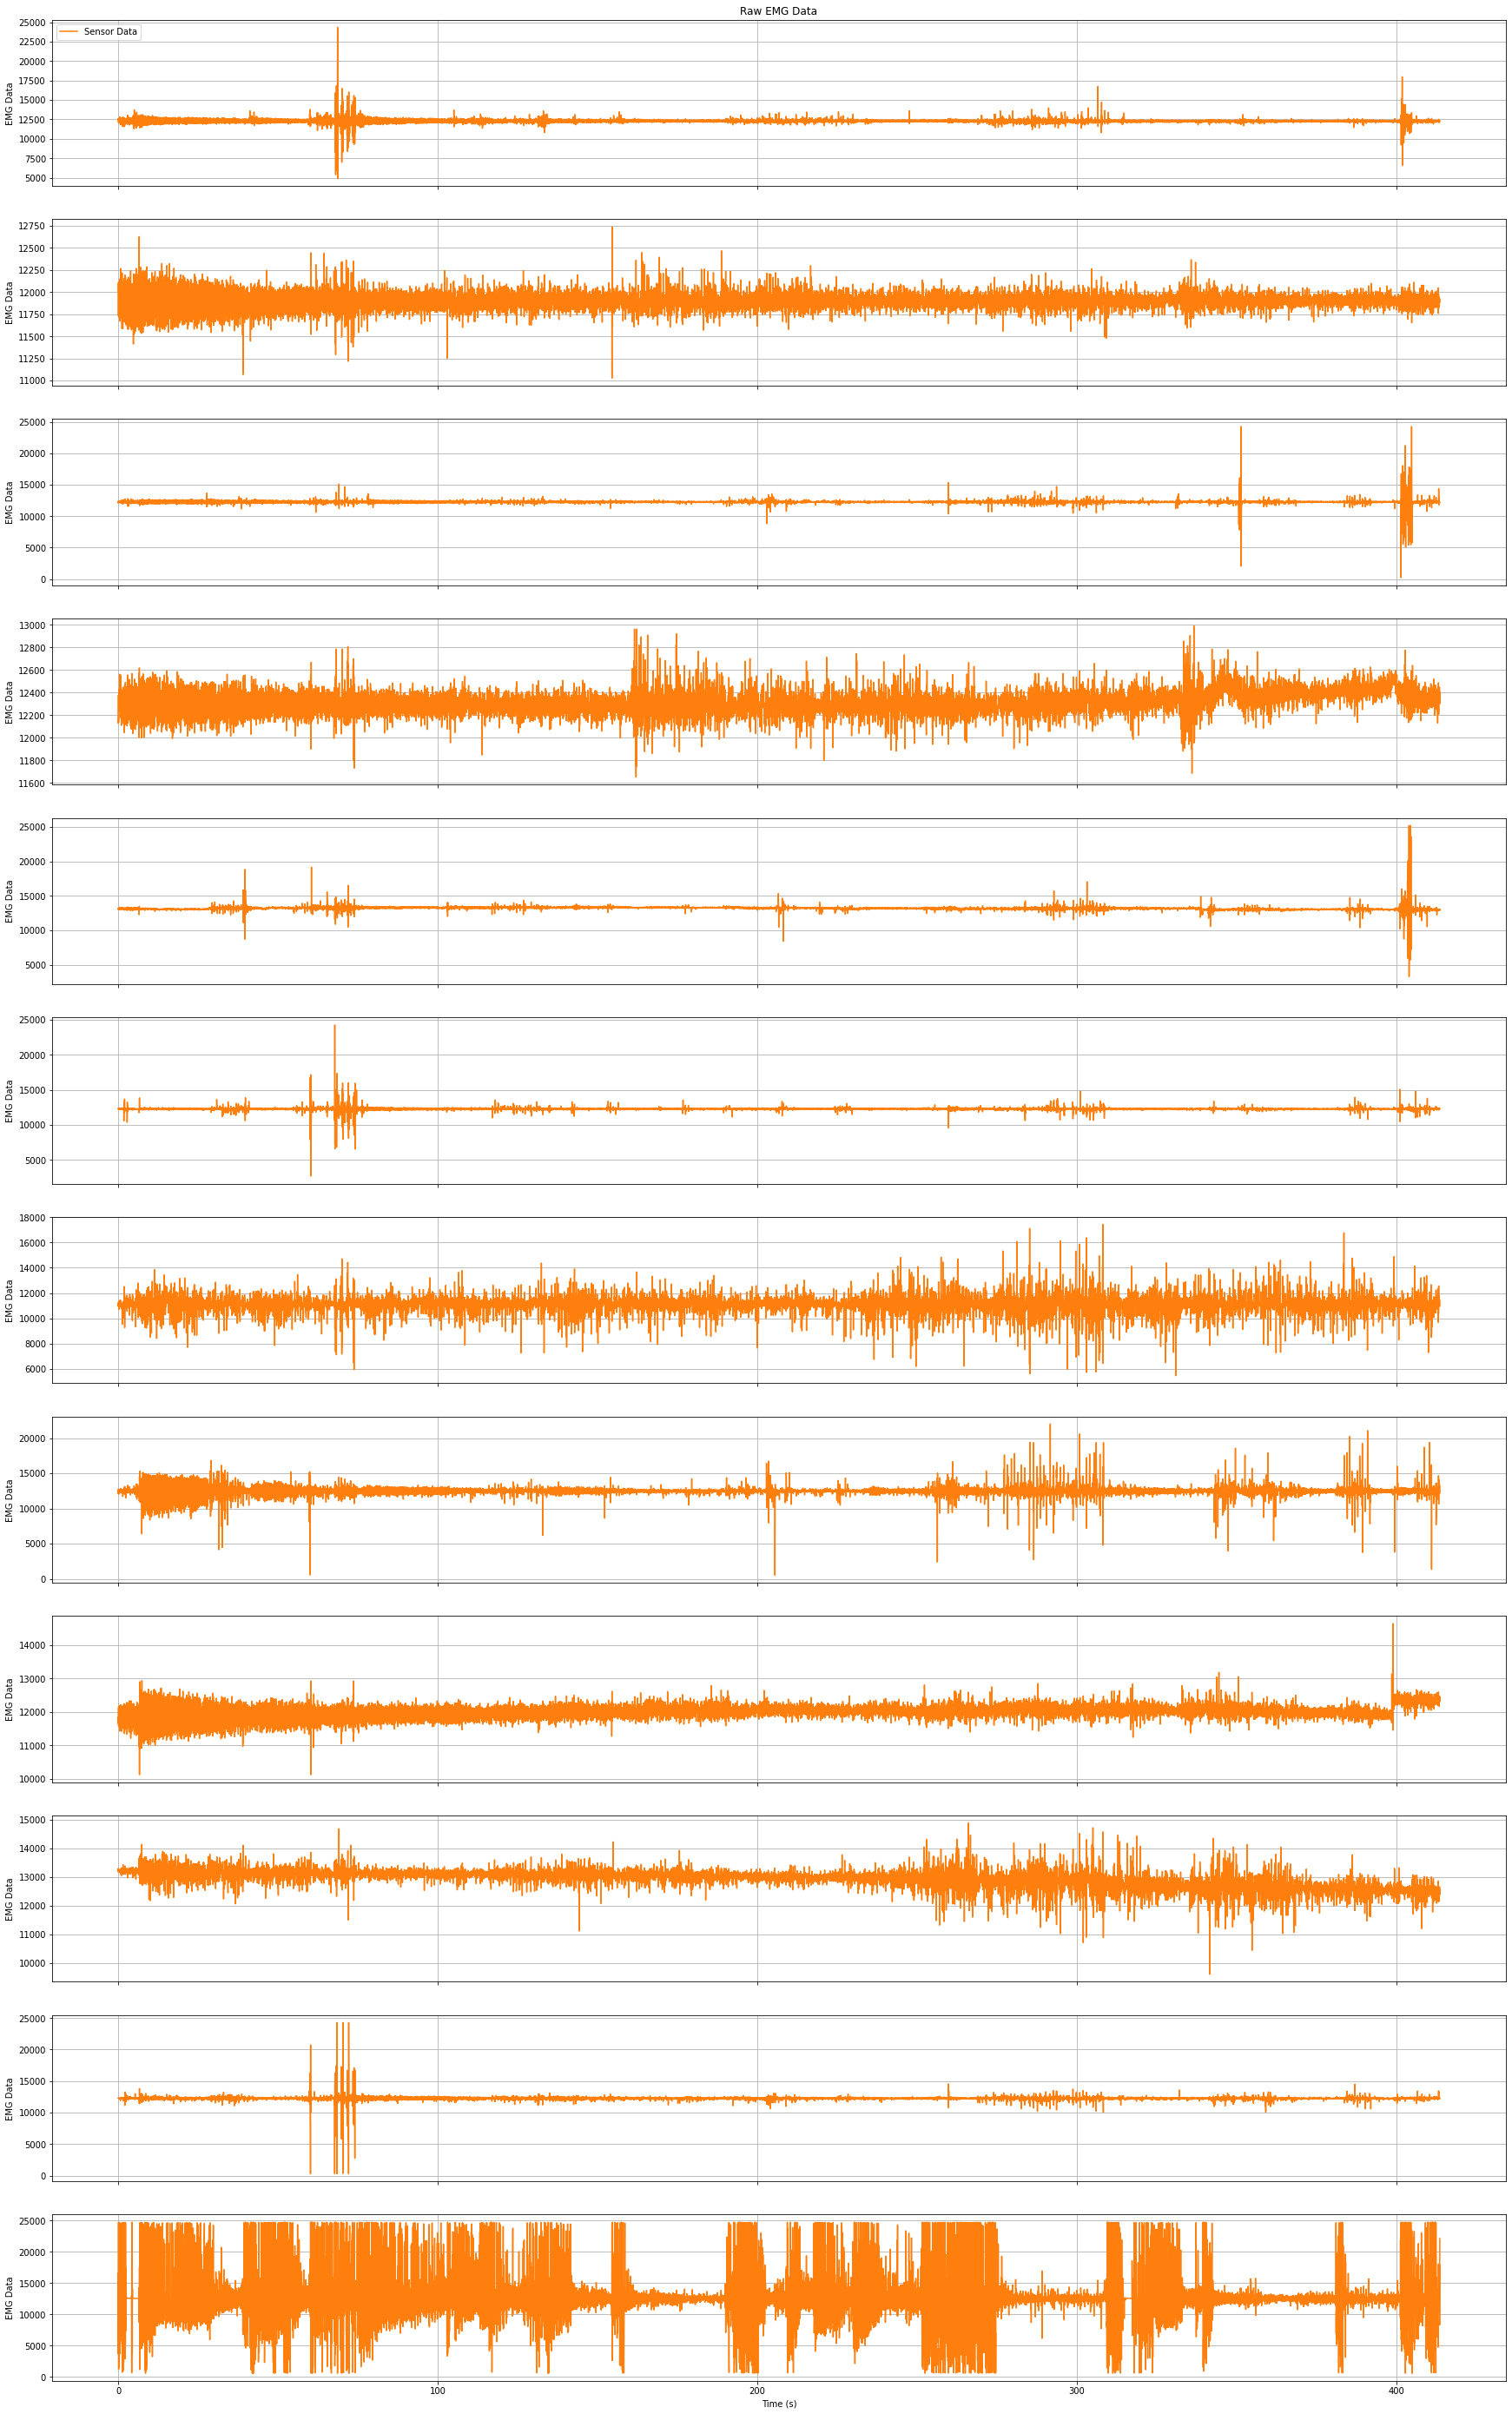

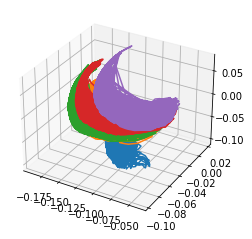

In [110]:
# Plot
# %matplotlib widget
import matplotlib.pyplot as plt

# Remove extraneous time data
tF0 = tF - tF[0]

# EMG Plots
plt.rc('font', size=10)
fig0, ax0 = plt.subplots(12, figsize=(30, 50), sharex=True)

for i in range(emgF.shape[-1]):
    ax0[i].plot(tF0, abs(emgF[:,i]), color='tab:orange', label='Sensor Data')
    ax0[i].grid(True)
    ax0[i].set_ylabel('EMG Data')

ax0[emgF.shape[-1] - 1].set_xlabel('Time (s)')
ax0[0].legend(loc='upper left')
ax0[0].set_title('Raw EMG Data')

# Thumbtip (19) and Index Fingertip (20) Positions (see ovrbone numbering scheme)
plt.figure()
ax1 = plt.axes(projection='3d')
for i in range(19,24):
    ax1.plot3D(qF[:,i*DIM], qF[:,i*DIM+1], qF[:,i*DIM+2])
ax1.view_init(30, 180)

for angle in range(0, 360, 60):
    ax1.view_init(30, angle)
    plt.draw()

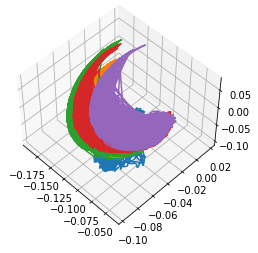

In [124]:
# Thumbtip (19) and Index Fingertip (20) Positions (see ovrbone numbering scheme)
plt.figure()
ax1 = plt.axes(projection='3d')
for i in range(19,24):
    ax1.plot3D(qF[:,i*DIM], qF[:,i*DIM+1], qF[:,i*DIM+2])
ax1.view_init(50, -45)


In [5]:
# Extract Individual Finger Features
thumb = qF[:,3*DIM:6*DIM]
index = qF[:,6*DIM:9*DIM]
middle = qF[:,9*DIM:12*DIM]
ring = qF[:,12*DIM:15*DIM]
pinkey = qF[:,15*DIM:19*DIM]

# And fingertip positions for minimal prediction scheme
fingertips = qF[:,19*DIM:]

print(index.shape)
print(fingertips.shape)

(11142, 9)
(11142, 15)


In [101]:
# Save to Files to Run on Colab
np.savetxt('EMGOut.txt', emgF, delimiter=",")
np.savetxt('qOut.txt', qF, delimiter=",")
np.savetxt('tOut.txt', tF, delimiter=",")
# np.savetxt('timestampsOut.txt', timestampsF, delimiter=",")


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [128]:
# Preliminary Data Operations
emgModel = emgF
qModel = fingertips[:,:3]
input_shape = emgModel.shape[-1]
output_shape = qModel.shape[-1]

# Split into train, validation, and test sets; normalize to mean/std of train set
nSamples_trn = int(0.5 * len(emgModel))
nSamples_val = int(0.25 * len(emgModel))
nSamples_tst = len(emgModel) - nSamples_trn - nSamples_val
print("Number of Training Samples: ", nSamples_trn)
print("Number of Validation Samples: ", nSamples_val)
print("Number of Test Samples: ", nSamples_tst)

# Normalize
emgModelMean = emgModel[:nSamples_trn,:].mean(axis = 0)
emgModelStd = emgModel[:nSamples_trn,:].std(axis = 0)
emgModel = (emgModel - emgModelMean)/emgModelStd

print("emgModel shape:", emgModel.shape)
print("qModel shape:", qModel.shape)
print(np.std(qModel, axis = 0))

Number of Training Samples:  5571
Number of Validation Samples:  2785
Number of Test Samples:  2786
emgModel shape: (11142, 12)
qModel shape: (11142, 3)
[0.00836679 0.01150559 0.03102362]


In [ ]:
# Feature Production

from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
# Shapelet feature extraction per timseries book
# Documentation nonexistent; see 
# https://github.com/alan-turing-institute/sktime/blob/main/sktime/transformations/panel/shapelet_transform.py
shapeletTransform = RandomShapeletTransform(
    max_shapelets=50,
    time_limit_in_minutes = 3
    )
shapeletTransform.fit(emgModel, qModel)
emgModelShapelet = shapeletTransform(emgModel)

# # Compute Possible Useful Features
# zero_crossings = np.where(np.diff(np.sign(array)))[0]
# waveformLength = np.sum(np.diff(array))
# wilson_amplitude = np.abs()
# mean_absolute_value = np.average(np.abs(array))
# mean_square = np.average(np.square(array))
# root_mean_square = np.sqrt(mean_square)
# v_order_three = np.power(np.average(np.power(array, 3)), 1/3)
# log_detector = np.exp(np.average(np.log(array)))

In [32]:
# Timeseries generation
sampling_rate = 1
delay = 1 # At present, only try to predict hand position at current timestep
sequence_length = 30 # from the data of the previous 50 timesteps
print("Using data from ", sequence_length*np.mean(np.diff(tF)), " seconds prior")
batch_size = 256

print("emgModel shape:", emgModel[:-delay, :].shape)

trn = keras.utils.timeseries_dataset_from_array(
 emgModel[:-delay, :],
 targets = qModel[delay:, :],
 sampling_rate = sampling_rate,
 sequence_length = sequence_length,
 shuffle = True,
 batch_size = batch_size,
 start_index = 0,
 end_index = nSamples_trn)

val = keras.utils.timeseries_dataset_from_array(
 emgModel[:-delay, :],
 targets = qModel[delay:, :],
 sampling_rate = sampling_rate,
 sequence_length = sequence_length,
 shuffle = True,
 batch_size = batch_size,
 start_index = nSamples_trn,
 end_index = nSamples_trn + nSamples_val)

tst = keras.utils.timeseries_dataset_from_array(
 emgModel[:-delay, :],
 targets = qModel[delay:, :],
 sampling_rate = sampling_rate,
 sequence_length = sequence_length,
 shuffle = True,
 batch_size = batch_size,
 start_index = nSamples_trn + nSamples_val)

for samples, targets in trn:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

Using data from  1.1139616346928496  seconds prior
emgModel shape: (11141, 12)
samples shape: (256, 30, 12)
targets shape: (256, 3)


In [74]:
# Naive Method: Guess a realtive position of zero for all fingertips
def evaluate_naive_method(dataset):
    total_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # print("Shapes: ", samples.shape, targets.shape)
        preds = np.zeros((1, output_shape))
        total_err += np.sum(np.square(preds - targets))
        samples_seen += samples.shape[0]
    return np.sqrt(total_err/samples_seen)
print("RMSE chosen to correspond to mean Euclidian distance error.")
print(f"Validation RMSE: {evaluate_naive_method(val):.4f}") 
print(f"Test RMSE: {evaluate_naive_method(tst):.4f}")
naive_rmse_val = np.sqrt(np.sum(np.square(qModel[nSamples_trn:nSamples_trn+nSamples_val,:]-qModel[nSamples_trn,:]))/nSamples_val)
naive_rmse_tst = np.sqrt(np.sum(np.square(qModel[nSamples_trn+nSamples_val:,:]-qModel[nSamples_trn+nSamples_val,:]))/nSamples_tst)
print(f"Naive RMSE val: {naive_rmse_val:.8f}")
print(f"Naive RMSE tst: {naive_rmse_tst:.8f}")

RMSE chosen to correspond to mean Euclidian distance error.
Validation RMSE: 0.1336
Test RMSE: 0.1318
Naive RMSE val: 0.03926308
Naive RMSE tst: 0.05090558


In [38]:
# Baseline model
inputs = keras.Input(shape = (sequence_length, emgModel.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dense(4, activation="relu")(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("fingertip_dense.keras",
 save_best_only=True)
] 
model.compile(optimizer = "rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs = 25,
 validation_data = val,
 callbacks=callbacks)
model = keras.models.load_model("fingertip_dense.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/25
22/22 [==============================] - 2s 21ms/step - loss: 0.0112 - root_mean_squared_error: 0.1056 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 2/25
22/22 [==============================] - 0s 11ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 3/25
22/22 [==============================] - 0s 11ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 4/25
22/22 [==============================] - 0s 13ms/step - loss: 5.9480e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 5/25
22/22 [==============================] - 0s 12ms/step - loss: 4.4946e-04 - root_mean_squared_error: 0.0212 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 6/25
22/22 [==============================] - 0s 11ms/step - loss: 4.3248e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0012 

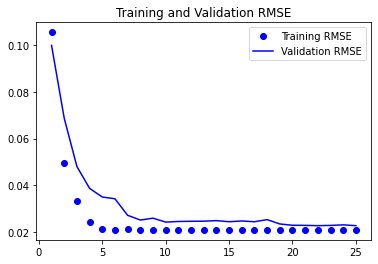

In [39]:
loss = history.history["root_mean_squared_error"]
val_loss = history.history["val_root_mean_squared_error"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training RMSE")
plt.plot(epochs, val_loss, "b", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.legend()

In [88]:
# Naive Neural Net Method
print(sequence_length, input_shape)
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.Conv1D(8, 16, activation="relu", padding="causal")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 8, activation="relu", padding="causal")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 4, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("fingertips_nn.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=20,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model("fingertips_nn.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

30 12
Epoch 1/20
22/22 [==============================] - 4s 45ms/step - loss: 0.1076 - root_mean_squared_error: 0.3281 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1356
Epoch 2/20
22/22 [==============================] - 1s 29ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 3/20
22/22 [==============================] - 1s 29ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 4/20
22/22 [==============================] - 1s 28ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 5/20
22/22 [==============================] - 1s 26ms/step - loss: 9.7847e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 6/20
22/22 [==============================] - 1s 26ms/step - loss: 6.4423e-04 - root_mean_squared_error: 0.0254 - val_loss: 7.020

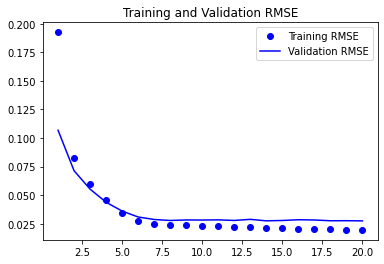

In [133]:
loss = history.history["root_mean_squared_error"]
val_loss = history.history["val_root_mean_squared_error"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training RMSE")
plt.plot(epochs, val_loss, "b", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.legend()

In [75]:
# Basic LSTM
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("fingertips_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=20,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model("fingertips_lstm.keras") 
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/20
22/22 [==============================] - 8s 94ms/step - loss: 0.0154 - root_mean_squared_error: 0.1242 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 2/20
22/22 [==============================] - 1s 29ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 3/20
22/22 [==============================] - 1s 32ms/step - loss: 0.0044 - root_mean_squared_error: 0.0662 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730
Epoch 4/20
22/22 [==============================] - 1s 37ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 5/20
22/22 [==============================] - 1s 34ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 6/20
22/22 [==============================] - 1s 27ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 0.0024 - val_root_m

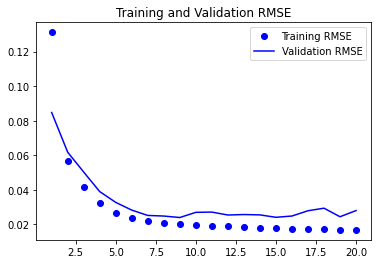

In [43]:
loss = history.history["root_mean_squared_error"]
val_loss = history.history["val_root_mean_squared_error"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training RMSE")
plt.plot(epochs, val_loss, "b", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.legend()

In [45]:
# Basic Stacked GRU
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("fingertips_stacked_gru_dropout.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=10,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model("fingertips_stacked_gru_dropout.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/10
22/22 [==============================] - 10s 97ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 2/10
22/22 [==============================] - 1s 54ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 3/10
22/22 [==============================] - 1s 57ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 4/10
22/22 [==============================] - 1s 53ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 7.6134e-04 - val_root_mean_squared_error: 0.0276
Epoch 5/10
22/22 [==============================] - 1s 58ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 6.1858e-04 - val_root_mean_squared_error: 0.0249
Epoch 6/10
22/22 [==============================] - 1s 54ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 4.6769e-04

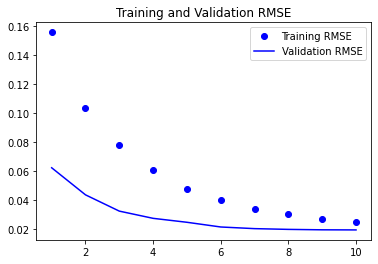

In [46]:
loss = history.history["root_mean_squared_error"]
val_loss = history.history["val_root_mean_squared_error"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training RMSE")
plt.plot(epochs, val_loss, "b", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.legend()

In [80]:
# Basic Stacked GRU
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.Conv1D(64, 3, activation="relu", padding="causal")(inputs)
x = layers.BatchNormalization()(x)
x = layers.GRU(512, dropout = 0.1, recurrent_dropout = 0, return_sequences = True)(x)
x = layers.GRU(512, dropout = 0.1, recurrent_dropout = 0)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(output_shape, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("fingertips_literature_gru.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=20,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model("fingertips_literature_gru.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/20
22/22 [==============================] - 33s 1s/step - loss: 0.1607 - root_mean_squared_error: 0.4008 - val_loss: 0.0739 - val_root_mean_squared_error: 0.2719
Epoch 2/20
22/22 [==============================] - 20s 927ms/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 3/20
22/22 [==============================] - 21s 960ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 4/20
22/22 [==============================] - 20s 915ms/step - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 5/20
22/22 [==============================] - 21s 937ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 6/20
22/22 [==============================] - 20s 927ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0079 - v

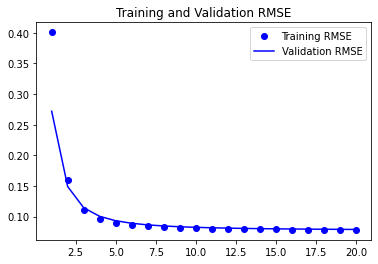

In [81]:
loss = history.history["root_mean_squared_error"]
val_loss = history.history["val_root_mean_squared_error"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training RMSE")
plt.plot(epochs, val_loss, "b", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.legend()

In [94]:
# Basic Stacked GRU
inputs = keras.Input(shape=(sequence_length, input_shape))
# x = layers.Conv1D(32, 12)(inputs)
# x = layers.BatchNormalization()(x)
x = layers.GRU(128, dropout = 0.8, recurrent_dropout = 0.8, return_sequences = True)(inputs)
x = layers.GRU(128, dropout = 0.8, recurrent_dropout = 0.8)(x)
x = layers.Dense(30)(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("fingertips_literature_gru.keras",
 save_best_only=True)
]
# opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=10,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model("fingertips_literature_gru.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/10
22/22 [==============================] - 21s 306ms/step - loss: 0.0361 - root_mean_squared_error: 0.1899 - val_loss: 8.0883e-04 - val_root_mean_squared_error: 0.0284
Epoch 2/10
22/22 [==============================] - 5s 216ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 4.1884e-04 - val_root_mean_squared_error: 0.0205
Epoch 3/10
22/22 [==============================] - 5s 203ms/step - loss: 0.0031 - root_mean_squared_error: 0.0552 - val_loss: 3.7508e-04 - val_root_mean_squared_error: 0.0194
Epoch 4/10
22/22 [==============================] - 5s 214ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 3.4624e-04 - val_root_mean_squared_error: 0.0186
Epoch 5/10
22/22 [==============================] - 4s 198ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 3.6296e-04 - val_root_mean_squared_error: 0.0191
Epoch 6/10
22/22 [==============================] - 4s 201ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - va

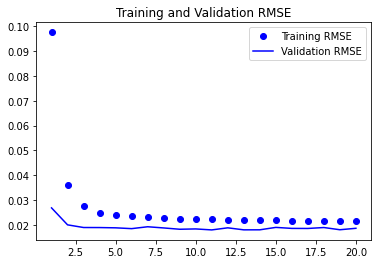

In [92]:
loss = history.history["root_mean_squared_error"]
val_loss = history.history["val_root_mean_squared_error"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training RMSE")
plt.plot(epochs, val_loss, "b", label="Validation RMSE")
plt.title("Training and Validation RMSE")
plt.legend()

In [100]:
# Basic Stacked GRU
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.Conv1D(64, 16, activation="relu", padding="causal")(inputs)
x = layers.BatchNormalization()(x)
x = layers.GRU(512, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = True)(x)
x = layers.GRU(512, dropout = 0.5, recurrent_dropout = 0.5)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(output_shape, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("fingertips_literature_gru.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=20,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model("fingertips_literature_gru.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")

Epoch 1/20
22/22 [==============================] - 52s 2s/step - loss: 0.1615 - root_mean_squared_error: 0.4018 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1720
Epoch 2/20
22/22 [==============================] - 33s 2s/step - loss: 0.0235 - root_mean_squared_error: 0.1535 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 3/20
22/22 [==============================] - 33s 2s/step - loss: 0.0115 - root_mean_squared_error: 0.1071 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881
Epoch 4/20
22/22 [==============================] - 32s 1s/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 5/20
22/22 [==============================] - 32s 1s/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820
Epoch 6/20
22/22 [==============================] - 32s 1s/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0065 - val_root_mean_sq

In [102]:
model = keras.models.load_model("fingertips_literature_gru.keras")
print(model.summary())

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 30, 12)]          0         
                                                                 
 conv1d_24 (Conv1D)          (None, 30, 64)            12352     
                                                                 
 batch_normalization_10 (Bat  (None, 30, 64)           256       
 chNormalization)                                                
                                                                 
 gru_32 (GRU)                (None, 30, 512)           887808    
                                                                 
 gru_33 (GRU)                (None, 512)               1575936   
                                                                 
 dense_51 (Dense)            (None, 256)               131328    
                                                          

In [ ]:
# Basic Stacked GRU
inputs = keras.Input(shape=(sequence_length, input_shape))
x = layers.Conv1D(32, 16, activation="relu", padding="causal")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(32, 8, activation="relu", padding="causal")(x)
x = layers.MaxPooling1D(2)(x)
# # x = layers.BatchNormalization()(x)
# x = layers.GRU(16, dropout = 0, recurrent_dropout = 0.5, return_sequences = True)(x)
# x = layers.GRU(16, dropout = 0, recurrent_dropout = 0.5)(x)
x = layers.Dense(16)(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
print(model.summary())
callbacks = [
 keras.callbacks.ModelCheckpoint("fingertips_literature_gru.keras",
 save_best_only=True)
]
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(trn,
 epochs=10,
 validation_data=val,
 callbacks=callbacks)
model = keras.models.load_model("fingertips_literature_gru.keras")
print(f"Test RMSE: {model.evaluate(tst)[1]:.4f}")